# Dynamic Time Warping (DTW)

Dynamic Time Warping (DTW) is a technique used to measure the similarity between two sequences of temporal events, accommodating variations in their speeds. In this project, I intend to utilize DTW to assess the similarity between specific audio tracks: "My Flame" by Bobby Caldwell, "Sky's the Limit" by The Notorious B.I.G. (which samples "My Flame"), and "Take Five" by Dave Brubeck.

- Song 1 - My Flame by Bobby Caldwell (https://www.youtube.com/watch?v=3hK6IgvZ0CY)
- Song 2 - Sky's the Limit by The Notorious B.I.G. (https://www.youtube.com/watch?v=d3vOeCkeCNA)
- Song 3 - Take Five by Dave Brubeck (https://www.youtube.com/watch?v=vmDDOFXSgAs)

It's noteworthy that Song 2 ("Sky's the Limit") is sampled from Song 1 ("My Flame"), while Song 3 ("Take Five") is entirely distinct from the first two songs.

For the purpose of this project, DTW will be applied solely to the instrumental versions of the songs. Due to computational considerations, the analysis will focus on the initial 30 seconds of each track. By employing DTW on these selected segments, I aim to compute similarity scores and quantify the degree of resemblance between the songs.

In [109]:
import os
from dtw import *
import numpy as np
import librosa
import librosa.display
import moviepy.editor as mp
import matplotlib.pyplot as plt
from IPython.display import Audio

### 1) Converting the .mp4 files into .wav files

In this section, I will be extracting the audio content from the .mp4 video files (which I downloaded) and converting them into the widely used .wav audio format. This step is essential for further analysis and processing of the audio data. Each .mp4 file will be processed to produce a corresponding .wav file, focusing on the audio component for subsequent Dynamic Time Warping (DTW) analysis.

In [2]:
# Load the MP4 files and extract audio
def extract_audio(video_path, audio_path):
    for file in os.listdir(video_path):
        if file.endswith('.mp4'):
            video_file = os.path.join(video_path, file)
            audio_file = os.path.join(audio_path, os.path.splitext(file)[0] + '.wav')

            video = mp.VideoFileClip(video_file)
            audio = video.audio
            
            # Extract the first 30 seconds of audio
            audio = audio.subclip(0, 30)
            audio.write_audiofile(audio_file)

In [3]:
# Directory paths for MP4 videos and audio output
video_path = './videos'  
audio_path = './audio_output'  

In [4]:
# Extract audio for all MP4 files in the specified video path
extract_audio(video_path, audio_path)

MoviePy - Writing audio in ./audio_output\My_Flame.wav


MoviePy - Done.
MoviePy - Writing audio in ./audio_output\Skys_The_Limit.wav


MoviePy - Done.
MoviePy - Writing audio in ./audio_output\Take_Five.wav


MoviePy - Done.


In [113]:
# My Flame
y, f_s = librosa.load('./audio_output/My_Flame.wav', sr=16000)
Audio(y, rate=f_s)

In [114]:
# Skys The Limit
y, f_s = librosa.load('./audio_output/Skys_The_Limit.wav', sr=16000)
Audio(y, rate=f_s)

In [115]:
# Take Five
y, f_s = librosa.load('./audio_output/Take_Five.wav', sr=16000)
Audio(y, rate=f_s)

### 2) Loading the .wav files and visualizing their audio frequencies

A Mel spectrogram, also known as a Mel-frequency spectrogram, is a representation of an audio signal's frequency content in a way that is more perceptually relevant to human hearing. It's a popular tool used in speech and audio processing tasks. We will be using the librosa package to visualize our 3 songs with the help of a log Mel-frequency spectrogram. The logarithm (log) transformation is applied to the Mel spectrogram because it helps replicate the logarithmic perception of loudness by the human auditory system. This makes the visualization more aligned with how we perceive audio, especially at different frequencies and amplitudes. It's a common practice in audio processing to use the log scale to better capture the human auditory experience and highlight the relevant features for analysis.

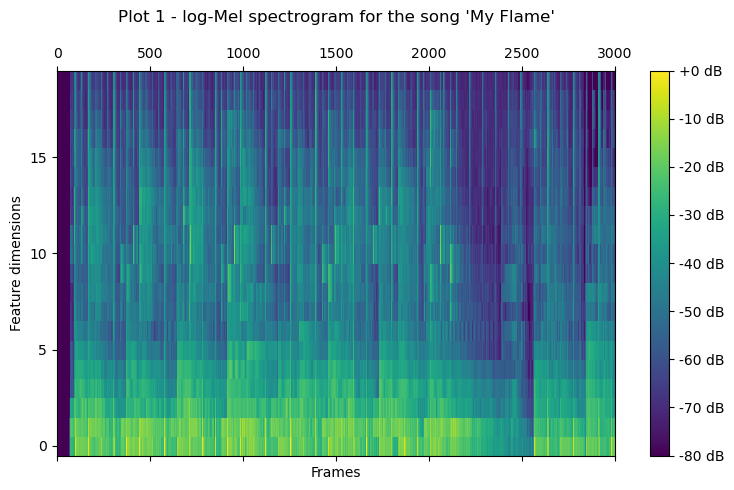

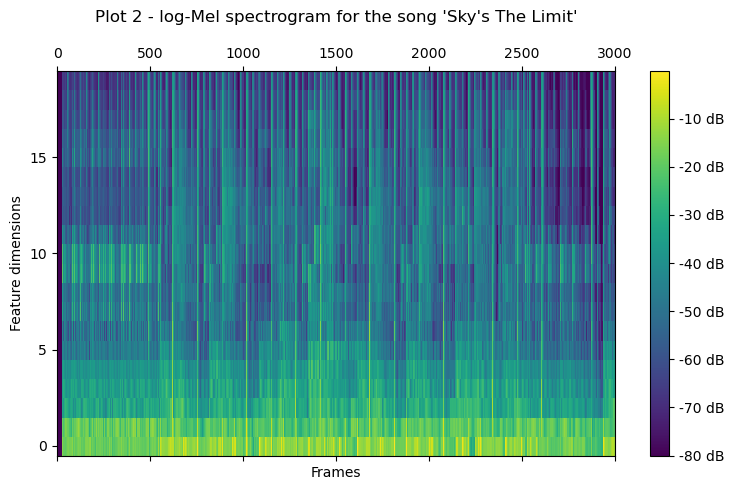

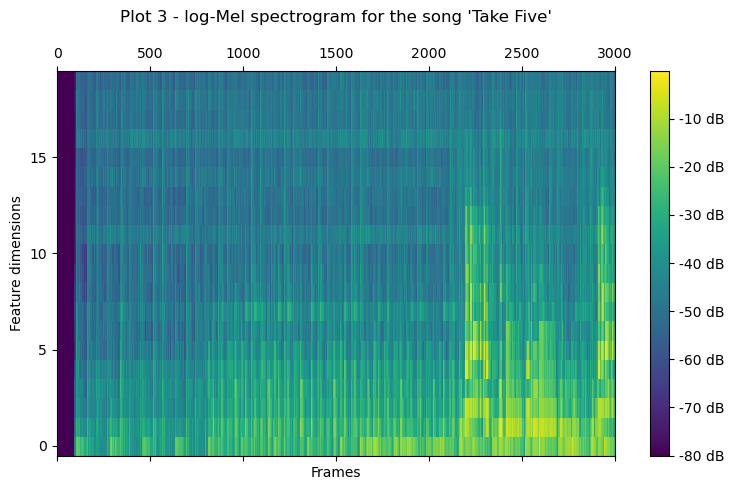

In [5]:
# Path to sample .wav music files
sample_paths = [
    './audio_output/My_Flame.wav',
    './audio_output/Skys_The_Limit.wav',
    './audio_output/Take_Five.wav'
]

songs = ["My Flame", "Sky's The Limit", "Take Five"]

# Iterate through sample paths and plot log-Mel spectrograms
for i, sample_path in enumerate(sample_paths):
    y, f_s = librosa.load(sample_path, sr=16000)  # Reducing the sampling rate to 16 kHz
    y = librosa.util.normalize(y.astype(np.float32))

    # Mel-scale spectrogram with reduced resolution and fewer mel bins
    n_fft = int(0.025 * f_s)      # 25 ms
    hop_length = int(0.01 * f_s)  # 10 ms
    n_mels = 20  # Reduce the number of mel bins
    mel_spec = librosa.feature.melspectrogram(
        y=y, sr=f_s, n_mels=n_mels,
        n_fft=n_fft, hop_length=hop_length
    )
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Plot log-Mel spectrogram
    fig, ax = plt.subplots(figsize=(9, 5))
    cax = ax.matshow(log_mel_spec, origin="lower", cmap='viridis', aspect='auto', vmin=-80)
    plt.ylabel("Feature dimensions")
    plt.xlabel("Frames")
    plt.title(f"Plot {i+1} - log-Mel spectrogram for the song '{songs[i]}'", pad=35)
    plt.colorbar(cax, format='%+2.0f dB')
    plt.show()

As we could see from the above plots, plots 1 and 2 have very similar features whereas plot 3 has completely different feature from the other 2 plots

### 3) Performing DTW

With the assistance of Dynamic Time Warping (DTW), we can determine the alignment cost between the songs, providing insights into their level of similarity. DTW is particularly effective in comparing sequences with different speeds, making it well-suited for our task of comparing audio tracks.

To facilitate a more meaningful comparison, we will focus on the normalized alignment cost, a crucial metric derived from DTW. The normalized alignment cost is obtained by normalizing the alignment cost with respect to the lengths of the sequences being compared. It provides a standardized measure of similarity, enabling fair comparisons irrespective of sequence length.

In interpreting the results, a lower normalized alignment cost indicates a higher degree of similarity between the songs. Conversely, a higher normalized alignment cost signifies greater dissimilarity. This metric simplifies the assessment of similarity levels, aiding in the determination of how closely related the songs are in terms of their audio characteristics.

In [6]:
# Compute log Mel spectrograms for each song
log_mel_specs = []
for sample_path in sample_paths:
    y, f_s = librosa.load(sample_path, sr=16000)  # Reducing the sampling rate to 16 kHz

    # Mel-scale spectrogram with reduced resolution and fewer mel bins
    n_fft = int(0.025 * f_s)      # 25 ms
    hop_length = int(0.01 * f_s)  # 10 ms
    mel_spec = librosa.feature.melspectrogram(
        y=y, sr=f_s, n_mels=n_mels,
        n_fft=n_fft, hop_length=hop_length
    )
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Transpose for DTW analysis
    log_mel_spec = log_mel_spec.T

    log_mel_specs.append(log_mel_spec)

Normalized DTW Alignment Cost: 25.55814010748488


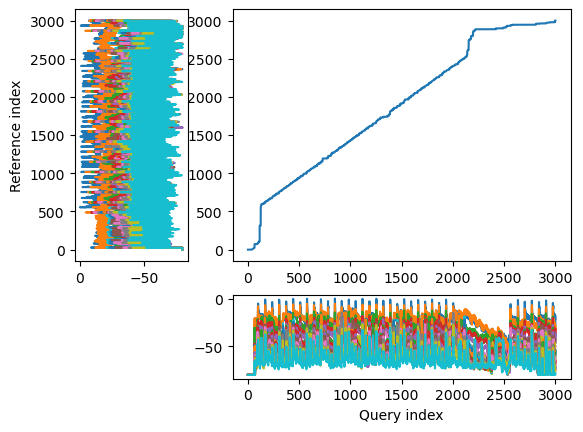

In [7]:
# Perform DTW between songs 1 and 2
query = log_mel_specs[0]
template = log_mel_specs[1]

# Perform DTW and calculate normalized cost
alignment = dtw(query, template, keep_internals=True)
normalized_alignment_cost = alignment.normalizedDistance

# Print the DTW normalized cost
print('Normalized DTW Alignment Cost:', normalized_alignment_cost)

alignment.plot(type="threeway")

plt.show()

Normalized DTW Alignment Cost: 33.36291113651092


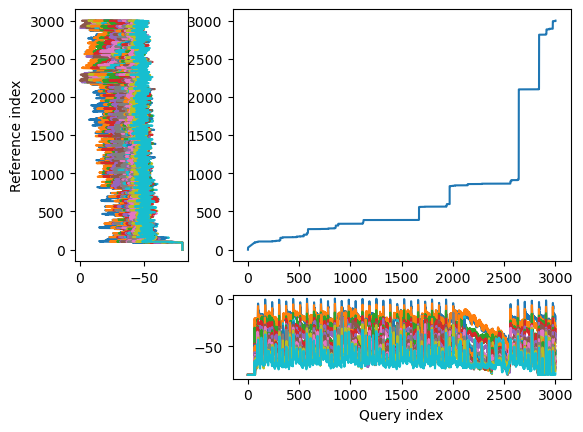

In [8]:
# Perform DTW between songs 1 and 3
query = log_mel_specs[0]
template = log_mel_specs[2]

# Perform DTW and calculate normalized cost
alignment = dtw(query, template, keep_internals=True)
normalized_alignment_cost = alignment.normalizedDistance

# Print the DTW normalized cost
print('Normalized DTW Alignment Cost:', normalized_alignment_cost)

alignment.plot(type="threeway")

plt.show()

Normalized DTW Alignment Cost: 34.95870119216688


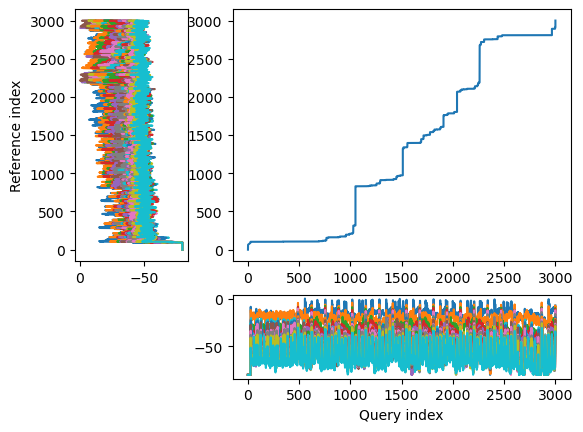

In [9]:
# Perform DTW between songs 2 and 3
query = log_mel_specs[1]
template = log_mel_specs[2]

# Perform DTW and calculate normalized cost
alignment = dtw(query, template, keep_internals=True)
normalized_alignment_cost = alignment.normalizedDistance

# Print the DTW normalized cost
print('Normalized DTW Alignment Cost:', normalized_alignment_cost)

alignment.plot(type="threeway")

plt.show()

Upon reviewing the results, it's evident that the alignment cost between songs 1 and 2 is notably lower compared to the alignment cost between songs 1 and 3, as well as between songs 2 and 3. This disparity in alignment costs strongly indicates a higher degree of similarity between songs 1 and 2. This aligns with the expectation, considering that song 2 is sampled from song 1. These results from DTW affirm the inherent musical resemblance between these two tracks.

# <u>Appendix</u>:

# Implementation without Built-in Packages

Credits - https://github.com/kamperh/lecture_dtw_notebook/blob/main/dtw.ipynb

In [84]:
def compute_dtw_matrix(dist_matrix):
    
    N, M = dist_matrix.shape
    
    dtw_matrix = np.zeros((N + 1, M + 1))
    dtw_matrix[0, :] = np.inf
    dtw_matrix[:, 0] = np.inf
    dtw_matrix[0, 0] = 0
    
    trace_matrix = np.zeros((N, M))
    
    for i in range(N):
        for j in range(M):
            cost = dist_matrix[i, j]
            val = (dtw_matrix[i, j], dtw_matrix[i + 1, j], dtw_matrix[i, j + 1])
            
            dtw_matrix[i + 1, j + 1] = cost + min(val)
            
            idx = np.argmin(val)
            
            trace_matrix[i, j] = idx
    
    # Traceback from bottom right
    i = N - 1
    j = M - 1
    route = [(i, j)]
    
    while i > 0 or j > 0:
        typ = trace_matrix[i, j]
        if typ == 0:
            i = i - 1
            j = j - 1
        elif typ == 1:
            j = j - 1
        elif typ == 2:
            i = i - 1
        route.append((i, j))
    
    dtw_matrix = dtw_matrix[1:, 1:]
    return (route[::-1], dtw_matrix)        

### <i>Univariate Example 1</i>

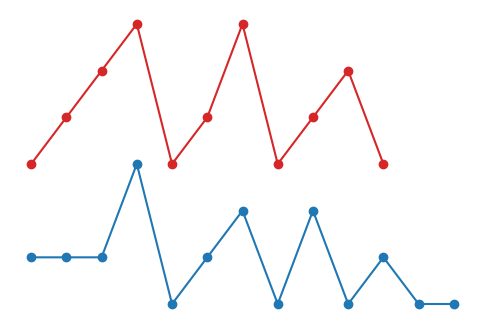

In [86]:
# Time series 1
a = np.array([0, 1, 2, 3, 0, 1, 3, 0, 1, 2, 0])

# Time series 2
b = np.array([1, 1, 1, 3, 0, 1, 2, 0, 2, 0, 1, 0, 0])

# Plot the original and sample time series
plt.figure(figsize=(6, 4))
plt.plot(np.arange(a.shape[0]), a + 1.5, "-o", c="C3")
plt.plot(np.arange(b.shape[0]), b - 1.5, "-o", c="C0")
plt.axis("off")
plt.show()

In [87]:
N = a.shape[0]
M = b.shape[0]

dist_matrix = np.zeros((N, M))

# Function to calculate Euclidean distance between two points
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

for idx1, val1 in enumerate(a):
    for idx2, val2 in enumerate(b):
        dist_matrix[idx1, idx2] = euclidean_distance(val1, val2)

Alignment cost: 5.0000
Normalized alignment cost: 0.2083


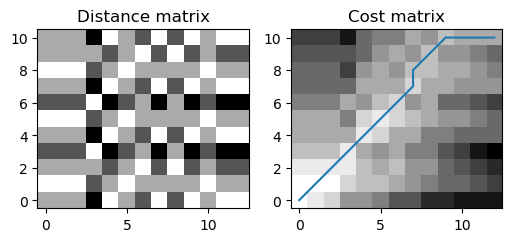

In [88]:
# DTW
path, cost_mat = compute_dtw_matrix(dist_matrix)
print("Alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]))
print("Normalized alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]/(N + M)))

plt.figure(figsize=(6, 4))
plt.subplot(121)
plt.title("Distance matrix")
plt.imshow(dist_matrix, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
plt.subplot(122)
plt.title("Cost matrix")
plt.imshow(cost_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_path, y_path = zip(*path)
plt.plot(y_path, x_path);

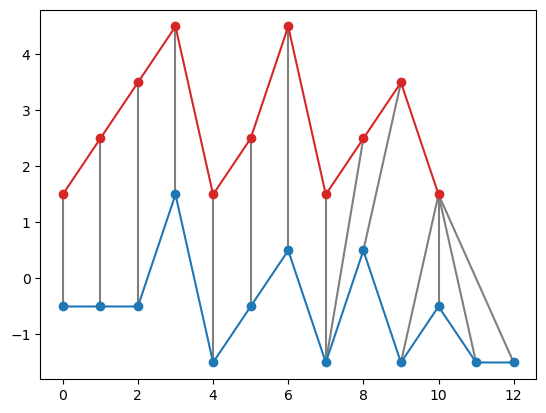

In [89]:
plt.figure()
for i, j in path:
    plt.plot([i, j], [a[i] + 1.5, b[j] - 1.5], c="C7")
plt.plot(np.arange(a.shape[0]), a + 1.5, "-o", c="C3")
plt.plot(np.arange(b.shape[0]), b - 1.5, "-o", c="C0")
plt.show()

Normalized DTW Alignment Cost: 0.25


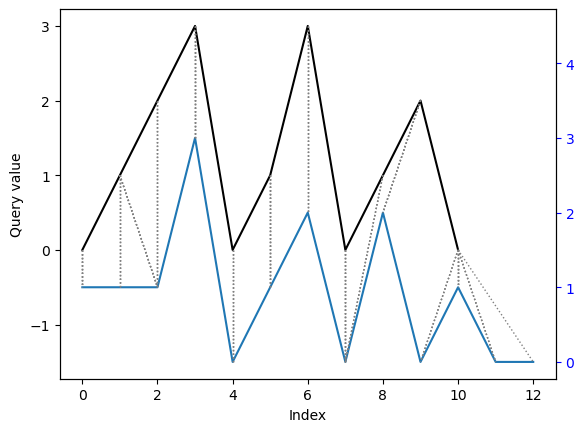

In [90]:
# Comparison with the builtin package dtw
alignment = dtw(a, b, keep_internals=True)
normalized_alignment_cost = alignment.normalizedDistance

# Print the DTW normalized cost
print('Normalized DTW Alignment Cost:', normalized_alignment_cost)

dtw(a, b, keep_internals=True).plot(type="twoway",offset=-1.5)

plt.show()

### <i>Univariate Example 2</i>

In [92]:
import random

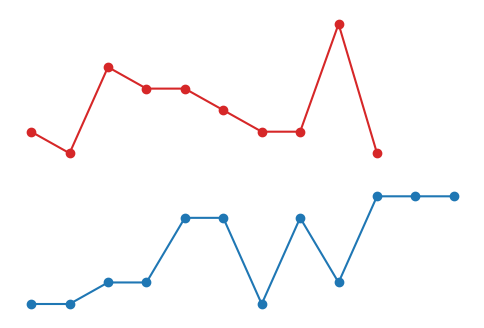

In [101]:
random.seed(42)

# Time series 1
a = np.array([random.randint(-2, 5) for _ in range(10)])

# Time series 2
b = np.array([random.randint(5, 10) for _ in range(12)])

# Plot the original and sample time series
plt.figure(figsize=(6, 4))
plt.plot(np.arange(a.shape[0]), a + 7, "-o", c="C3")
plt.plot(np.arange(b.shape[0]), b - 7, "-o", c="C0")
plt.axis("off")
plt.show()

In [102]:
N = a.shape[0]
M = b.shape[0]

dist_matrix = np.zeros((N, M))

# Function to calculate Euclidean distance between two points
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

for idx1, val1 in enumerate(a):
    for idx2, val2 in enumerate(b):
        dist_matrix[idx1, idx2] = euclidean_distance(val1, val2)

Alignment cost: 81.0000
Normalized alignment cost: 3.6818


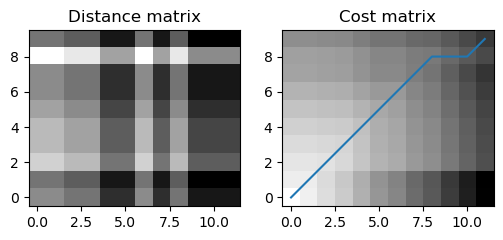

In [103]:
# DTW
path, cost_mat = compute_dtw_matrix(dist_matrix)
print("Alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]))
print("Normalized alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]/(N + M)))

plt.figure(figsize=(6, 4))
plt.subplot(121)
plt.title("Distance matrix")
plt.imshow(dist_matrix, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
plt.subplot(122)
plt.title("Cost matrix")
plt.imshow(cost_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_path, y_path = zip(*path)
plt.plot(y_path, x_path);

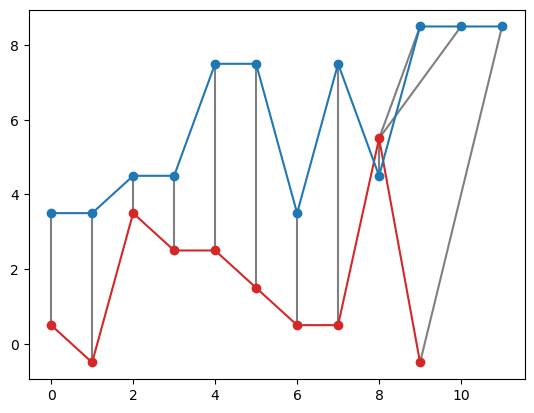

In [104]:
plt.figure()
for i, j in path:
    plt.plot([i, j], [a[i] + 1.5, b[j] - 1.5], c="C7")
plt.plot(np.arange(a.shape[0]), a + 1.5, "-o", c="C3")
plt.plot(np.arange(b.shape[0]), b - 1.5, "-o", c="C0")
plt.show()

Normalized DTW Alignment Cost: 4.318181818181818


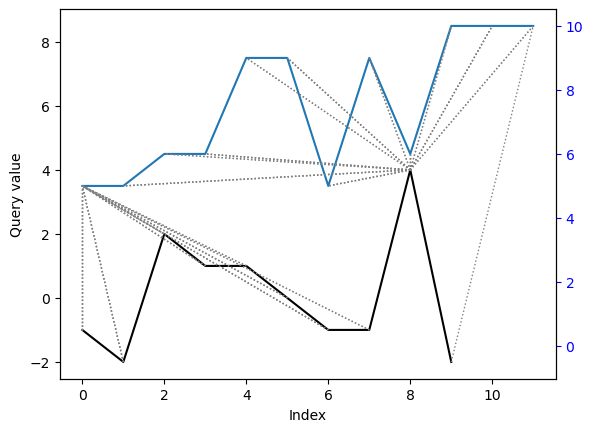

In [105]:
# Comparison with the built-in package dtw
alignment = dtw(a, b, keep_internals=True)
normalized_alignment_cost = alignment.normalizedDistance

# Print the DTW normalized cost
print('Normalized DTW Alignment Cost:', normalized_alignment_cost)

dtw(a, b, keep_internals=True).plot(type="twoway",offset=-1.5)

plt.show()